# Classifying YouTube Comments using Supervised Learning
In this notebook, we will use supervised learning techniques to classify YouTube comments. The goal is to categorize comments into different classes such as positive, negative etc. 

Let's get started!

In [26]:
from _functions import *

## Import and clean data
Import the data as a dataframe. Cleans the data sequentially.

### Data preprocessing
Clean the data to remove empty rows, row[0] containing the raw data to put the text into a form such that it is ready for BERT input.

In [84]:
# Import the data as dataframe
comments_df = pd.DataFrame(columns=["comment"])


current_dir = Path.cwd().parent

data_path = current_dir / "Data" / "RawData" 

for file_name in os.listdir(data_path):

    # Declare the file path
    file_path = data_path / file_name

    # Import the data
    df = pd.read_csv(file_path)
    clean_comments = clean_data(df).to_frame()
    comments_df = pd.concat([comments_df, clean_comments])

print(comments_df.shape)

(8948, 1)


### Clean the text

In [85]:
# NOTE : For importing the spacy embeddings model spacy package, run the 
#        following line in Anaconda prompt: 
#           conda install conda-forge::spacy-model-en_core_web_sm

# NOTE : We may need to go back and better handle emojis at some point. 

comments_df['cleaned_comment'] = comments_df['comment'].apply(preprocess_text)
comments_df['country'] = comments_df['cleaned_comment'].apply(extract_country)
comments_df['country'] = comments_df['country'].apply(lambda x: ['none'] if not x else x)

comments_df.head()

,comment,cleaned_comment,country
7,"It does not ""risk"" raising prices, it will ABS...",it does not risk raising prices it will absolu...,[none]
8,"Canada 🇨🇦 Your Oil , Timber and Critical Mine...",canada your oil timber and critical mineral...,[canada]
9,Stupid people gave a stupid man a stupid amoun...,stupid people gave a stupid man a stupid amoun...,[none]
10,"So punish your enemies, and then punish your f...",so punish your enemies and then punish your fr...,[none]
11,I am Canadian and i personally think we shoul...,i am canadian and i personally think we shoul...,[none]


## Sentiment Analysis Using VADER
Vader calculates the proportion of positive, negative, and neutral words in each comment and creates a compound score.

In [86]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis correctly
comments_df['sentiment_scores'] = comments_df['cleaned_comment'].apply(lambda x: analyzer.polarity_scores(x))
comments_df['compound_score'] = comments_df['sentiment_scores'].apply(lambda x: x['compound'])

print(comments_df[['cleaned_comment', 'sentiment_scores', 'compound_score']].head())

                                      cleaned_comment  \
7   it does not risk raising prices it will absolu...   
8   canada   your oil  timber and critical mineral...   
9   stupid people gave a stupid man a stupid amoun...   
10  so punish your enemies and then punish your fr...   
11  i am canadian and i personally think  we shoul...   

                                     sentiment_scores  compound_score  
7   {'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...          0.2057  
8   {'neg': 0.084, 'neu': 0.836, 'pos': 0.08, 'com...         -0.0258  
9   {'neg': 0.547, 'neu': 0.453, 'pos': 0.0, 'comp...         -0.9231  
10  {'neg': 0.487, 'neu': 0.369, 'pos': 0.143, 'co...         -0.8155  
11  {'neg': 0.051, 'neu': 0.855, 'pos': 0.095, 'co...          0.4404  


## Sentiment by Country

In [116]:
import re

# U.S. states, cities, and major regions mapped to "US"
us_locations = {
    "alabama", "alaska", "arizona", "arkansas", "california", "colorado", "connecticut", "delaware",
    "florida", "georgia", "hawaii", "idaho", "illinois", "indiana", "iowa", "kansas", "kentucky",
    "louisiana", "maine", "maryland", "massachusetts", "michigan", "minnesota", "mississippi", "missouri",
    "montana", "nebraska", "nevada", "new hampshire", "new jersey", "new mexico", "new york", 
    "north carolina", "north dakota", "ohio", "oklahoma", "oregon", "pennsylvania", "rhode island",
    "south carolina", "south dakota", "tennessee", "texas", "utah", "vermont", "virginia",
    "washington", "west virginia", "wisconsin", "wyoming", "new york city", "nyc", "los angeles",
    "chicago", "houston", "dallas", "miami", "las vegas", "cleveland", "detroit", "pittsburgh",
    "janesville", "mckinley", "calif", "murrica", "va", "la"
}

# Canadian provinces and major cities mapped to "Canada"
canadian_locations = {
    "toronto", "calgary", "alberta", "british columbia", "prince edward island",
    "manitoba", "saskatchewan", "nova scotia", "newfoundland", "quebec"
}

# Common country variations mapped to standard country names
country_map = {
    "us": "US", "usa": "US", "u s a": "US", "u s": "US", "america": "US",
    "united states": "US", "united states of america": "US", "the united states": "US",
    "murrica": "US",
    "cananda": "Canada", "actscanada": "Canada", "chinacanada": "Canada",
    "united kingdom": "United Kingdom", "uk": "United Kingdom", "great britain": "United Kingdom", 
    "britain": "United Kingdom", "england": "United Kingdom", "london": "United Kingdom",
    "prc": "China", "chine": "China", "china germany": "China", "shanghai": "China",
    "chinathankstommy": "China", "beijing": "China", "shanhai": "China",
    "russia rip america": "Russia", "soviet union": "Russia", "ussr": "Russia",
    "uae": "United Arab Emirates", "dubai": "United Arab Emirates",
    "south korea": "South Korea", "north korea": "North Korea",
    "mexeeeco": "Mexico", "mexico columbia": "Mexico", "retaliation mexico": "Mexico",
    "philippines": "Philippines", "taiwan": "Taiwan", "iran": "Iran",
    "new zealand": "New Zealand", "australia": "Australia",
    "brazil": "Brazil", "argentina": "Argentina", "nigeria": "Nigeria",
    "poland": "Poland", "germany": "Germany", "france": "France",
    "italy": "Italy", "spain": "Spain", "portugal": "Portugal",
    "thailand": "Thailand", "romania": "Romania", "columbia": "Colombia",
    "ukraine": "Ukraine", "switzerland": "Switzerland", "pakistan": "Pakistan",
    "bosnia": "Bosnia", "jamaica": "Jamaica", "hiroshima": "Japan",
    "bucharest romania": "Romania", "job mexico": "Mexico",
    "itchina": "Italy", "warsaw": "Poland"
}

# Words to remove (gibberish/unrelated text)
junk_words = {
    "netflix", "boycotts", "hahahah", "hahahaha", "quizas", "xrp", "mckinley mount",
    "mechina", "bidenobama", "trumps golden", "biden", "gawd", "bohica", "adolph",
    "djibouti", "ananswer", "danielle", "mansmh", "mmmmm", "eu",
    "waysmh", "quizas", "quran", "adolph", "hahahahaahahahahahah", "xaikxrp", "kinda",
    "answernnnnnoooooo", "ushe", "binden", "melania",    "netflix", "boycotts", "lake", "hahahah", "hahahaha", "quizas", "xrp", "mckinley mount",
    "mechina", "bidenobama", "trumps golden", "biden", "gawd", "bohica", "adolph",
    "djibouti", "ananswer", "danielle", "mansmh", "mmmm",
    "waysmh", "quizas", "quran", "adolph", "hahahahahaha", "hahahahaahahahahahah", 
    "hahahahaahahahahahah", "xaikxrp", "kinda","tariffmania",
    "answernnnnnoooooooooo", "ushe", "binden", "melania"
}

# Special words that should be checked for context (not outright removed)
context_words = {"lake", "gulf", "south", "the", "thw", "mount"}

# Function to clean country names while preserving context-dependent words
def clean_country_name(country):
    if not isinstance(country, str) or country.strip() == "":
        return None  # Ignore non-string values and empty strings
    
    country = country.strip().lower()  # Normalize case
    country = re.sub(r'[^a-z\s]', '', country)  # Remove non-alphabetic characters

    # Remove junk words
    if country in junk_words:
        return None  

    # If the name is just a context word (e.g., "South"), remove it
    words = country.split()
    if len(words) == 1 and words[0] in context_words:
        return None  

    # Check full country names before splitting words
    if country in country_map:
        return country_map[country]

    # Map U.S. locations to "US"
    if country in us_locations:
        return "US"

    # Map Canadian provinces/cities to "Canada"
    if country in canadian_locations:
        return "Canada"

    # Handle multi-country inputs
    cleaned_parts = []
    for word in words:
        mapped_word = country_map.get(word, word.capitalize())
        if mapped_word in cleaned_parts:
            continue
        cleaned_parts.append(mapped_word)

    # If there's more than one country, keep only the first valid country
    first_valid_country = cleaned_parts[0] if cleaned_parts else None

    return first_valid_country

# Apply function to the 'country' column
comments_df["cleaned_country"] = comments_df["country"].apply(
    lambda x: clean_country_name(x[0]) if isinstance(x, list) and x else clean_country_name(x)
)

# Remove invalid entries
countryanalysis_df = comments_df[comments_df["cleaned_country"].notna() & (comments_df["cleaned_country"] != "None")]


In [117]:
print(countryanalysis_df[['cleaned_country', 'compound_score']].head())

   cleaned_country  compound_score
8           Canada         -0.0258
13          Canada          0.6908
16              US          0.4939
17              US         -0.1531
18          Canada         -0.6249


In [118]:
unique_countries = countryanalysis_df['cleaned_country'].dropna().unique()
print(unique_countries)


['Canada' 'US' 'Mexico' 'China' 'Australia' 'Russia' 'Lake'
 'United Kingdom' 'India' 'The' 'Cuba' 'Japan' 'Poland' 'Panama'
 'Afghanistan' 'Colombia' 'Finland' 'Brazil' 'Gulf' 'South Korea'
 'Nigeria' 'Germany' 'Manirima' 'Taiwan' 'South' 'Netherlands' 'Spain'
 'Thailand' 'Somalia' 'France' 'Portugal' 'Turkey' 'Norway' 'Hungary'
 'New Zealand' 'Iraq' 'Romania' 'Iran' 'Israel' 'Malaysia' 'Algeria'
 'Argentina' 'Haiti' 'Jamaica' 'North Korea' 'Switzerland' 'Gaza'
 'Vietnam' 'Ukraine' 'Italy' 'Ireland' 'Pakistan' 'Bosnia' 'Bahamas'
 'Kenya' 'Indonesia' 'United Arab Emirates' 'Thw' 'Eu' 'Mount']


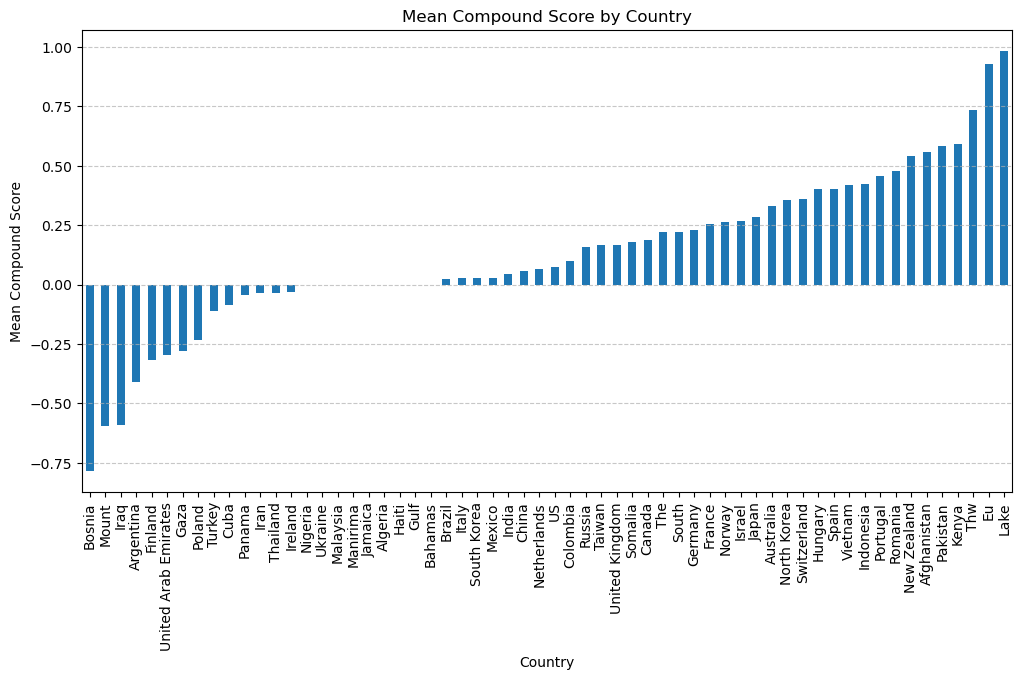

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate mean compound_score by country
mean_scores = countryanalysis_df.groupby("cleaned_country")["compound_score"].mean().sort_values()

# Create a bar plot
plt.figure(figsize=(12, 6))
mean_scores.plot(kind="bar")
plt.xlabel("Country")
plt.ylabel("Mean Compound Score")
plt.title("Mean Compound Score by Country")
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()
